# Adult Data Analysis

[PMR3508](https://uspdigital.usp.br/jupiterweb/obterDisciplina?sgldis=PMR3508) - Machine Learning and Pattern Recognition

Professor Fabio Gagliardi Cozman

10284952 - [Vitor Gratiere Torres](https://github.com/vitorgt)

This analysis consists in predicting whether someone has an income greater or lesser than 50k with attributes like level of education, age, work class, occupation, among others, and will be based on # steps as follows:

## 1. Import data

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

adult = pd.read_csv('adult-pmr3508/train_data.csv')
adult.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


## 2. Factorize

Encode objects as an enumerated type or categorical variable. This method is useful for obtaining a numeric representation of an array when all that matters is identifying distinct values.

Note: ```education``` is already factorized in ```education.num```. I've followed the same nomenclature for the following features.

In [2]:
uniques = {
}

adult['marital.status.num'], uniques['marital.status'] = pd.factorize(adult['marital.status'], sort=True)
adult['occupation.num'], uniques['occupation'] = pd.factorize(adult['occupation'], sort=True)
adult['relationship.num'], uniques['relationship'] = pd.factorize(adult['relationship'], sort=True)
adult['race.num'], uniques['race'] = pd.factorize(adult['race'], sort=True)
adult['sex.num'], uniques['sex'] = pd.factorize(adult['sex'], sort=True)
adult['native.country.num'], uniques['native.country'] = pd.factorize(adult['native.country'], sort=True)
adult['income'], uniques['income'] = pd.factorize(adult['income'], sort=True)

In [3]:
adult.describe()

,Id,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,income,marital.status.num,occupation.num,relationship.num,race.num,sex.num,native.country.num
count,32560.000000,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000
mean,32559.500000,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469,0.240817,2.611794,6.572912,1.446376,3.665848,0.669195,36.718796
std,9399.406719,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618,0.427586,1.506225,4.228809,1.606794,0.848817,0.470510,7.823892
min,16280.000000,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24419.750000,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000,0.000000,2.000000,3.000000,0.000000,4.000000,0.000000,39.000000
50%,32559.500000,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000,0.000000,2.000000,7.000000,1.000000,4.000000,1.000000,39.000000
75%,40699.250000,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000,0.000000,4.000000,10.000000,3.000000,4.000000,1.000000,39.000000
max,48839.000000,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000,6.000000,14.000000,5.000000,4.000000,1.000000,41.000000


array([[<AxesSubplot:title={'center':'Id'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'fnlwgt'}>,
        <AxesSubplot:title={'center':'education.num'}>],
       [<AxesSubplot:title={'center':'capital.gain'}>,
        <AxesSubplot:title={'center':'capital.loss'}>,
        <AxesSubplot:title={'center':'hours.per.week'}>,
        <AxesSubplot:title={'center':'income'}>],
       [<AxesSubplot:title={'center':'marital.status.num'}>,
        <AxesSubplot:title={'center':'occupation.num'}>,
        <AxesSubplot:title={'center':'relationship.num'}>,
        <AxesSubplot:title={'center':'race.num'}>],
       [<AxesSubplot:title={'center':'sex.num'}>,
        <AxesSubplot:title={'center':'native.country.num'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

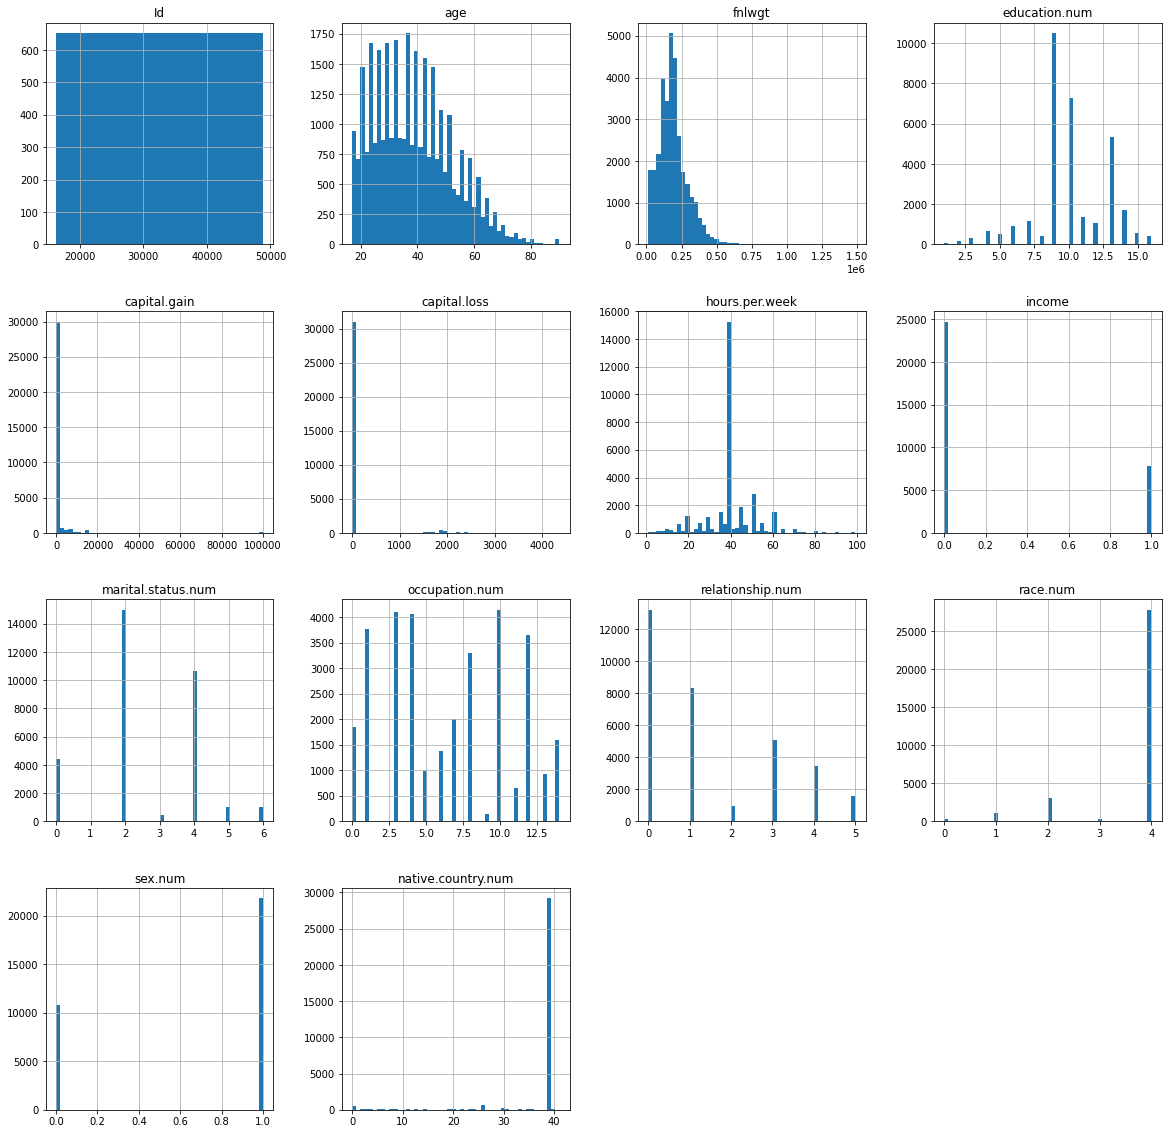

In [32]:
# fig, ax = plt.subplots(5, 3, figsize=(20,10))
# fig = plt.figure(figsize=(20, 80))

# for i in range(1, 16):
#     ax = fig.add_subplot(15,1,i)
#     ax.plot(np.asarray(adult.iloc[:,i].value_counts()))
#     ax.set_title(adult.columns[i])
#     print(np.asarray(adult.iloc[:,i].value_counts()))

# plt.show()

adult.hist(bins=50, figsize=(20,20))

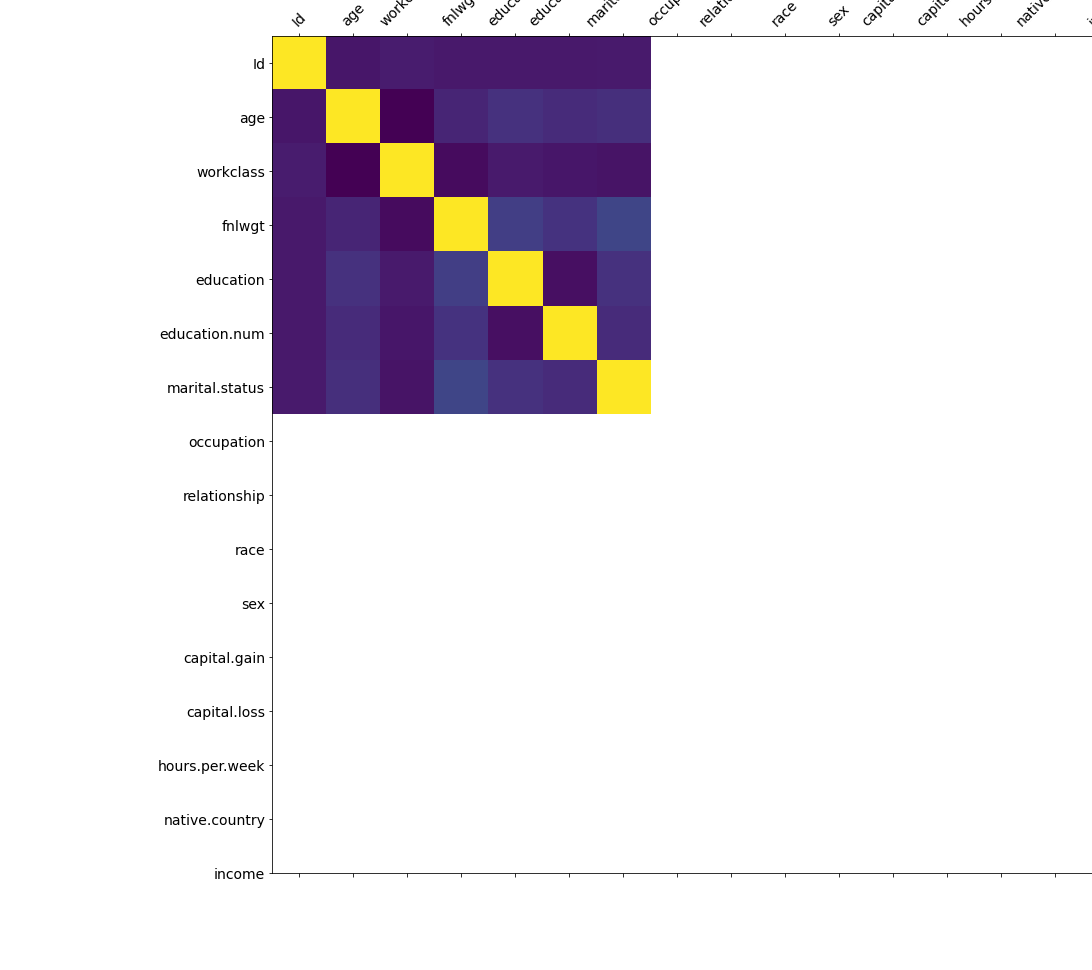

In [2]:
f = plt.figure(figsize=(20, 15))
plt.matshow(adult.corr(), fignum=f.number)
plt.xticks(range(adult.shape[1]), adult.columns, fontsize=14, rotation=45)
plt.yticks(range(adult.shape[1]), adult.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

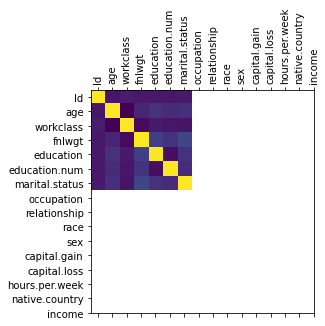

In [3]:
plt.matshow(adult.corr())
plt.xticks(range(adult.shape[1]), adult.columns, rotation=90)
plt.yticks(range(adult.shape[1]), adult.columns)
plt.show()

#### TODO

https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/